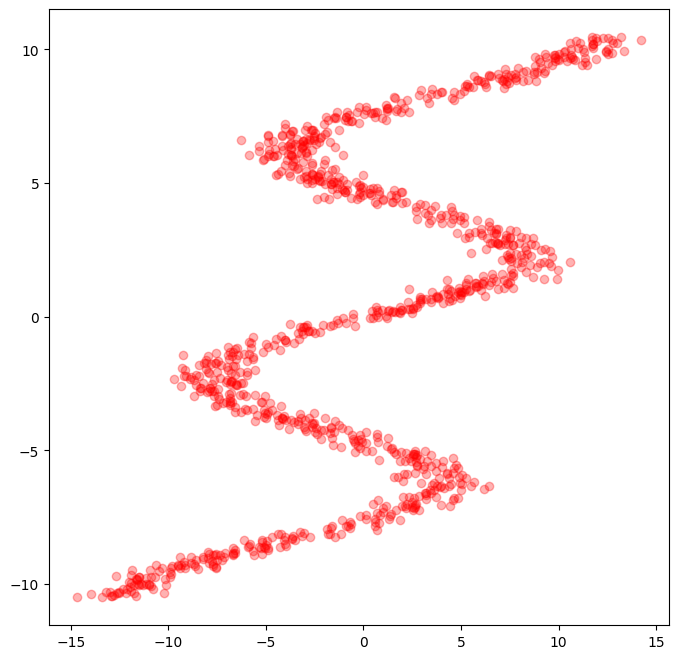

In [8]:
import numpy as np
import matplotlib.pyplot as plt

NSAMPLE = 1000

x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
tmp_data = x_data
r_data = np.float32(np.random.normal(size=(NSAMPLE, 1)))
y_data = np.float32(np.sin(0.75 * x_data) * 7.0 + x_data * 0.5 + r_data * 1.0)
x_data = y_data
y_data = tmp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.show()



For a given value x, the liklihood of x to happen in a distribution in $N(\mu, \sigma)$ is

$$
p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$



In [11]:
import sys
sys.path.append('..')
import dezero
import dezero.functions as F
import dezero.layers as L
import dezero.models as M
import math



NHIDDEN = 24
STDEV = 0.5
KMIX = 24
NOUT = KMIX * 3 # pi, mu, stdev



class MDN(dezero.Model):
    def __init__(self, n_input, n_hidden, n_gaussians):
        super().__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.z_h = M.Sequential(L.Linear(n_hidden), F.tanh)
        self.z_pi = L.Linear(n_hidden, n_gaussians)
        self.z_sigma = L.Linear(n_hidden, n_gaussians)
        self.z_mu = L.Linear(n_hidden, n_gaussians)
        

    def forward(self, inputs):
        z_h = self.z_h(inputs)
        pi = F.softmax(self.z_pi(z_h))
        sigma = F.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, mu, sigma
    
    # Sinvle variable gaussian
    def gaussian_1d_pdf(self, y, mu, sigma):
        oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
        # the result means the probability of y in the normal distribution
        # we check the probability of y in the normal distribution
        # if the probability is high, the result is close to 1
        # There is no
        result = F.sub(y, mu)  # y - mu
        result = F.div(result, sigma) # 이것은 sigma matrix를 역수로 바꾸고 곱한 것 # (y - mu) / sigma
        result = F.pow(result, 2) # 제곱 # (y - mu)^2 / sigma^2
        result = F.mul(result, -0.5) # -0.5 * (y - mu)^2 / sigma^2
        result = F.exp(result) # e^(-0.5 * (y - mu)^2 / sigma^2)
        # sigmd의 역수
        # https://kangbk0120.github.io/articles/2018-05/MDN
        # make a oneDivSqrtTwoPI tensor
        tmp_tensor = np.ones(sigma.shape) * oneDivSqrtTwoPI # 1 / sqrt(2 * pi)
        
        result = F.mul(result, F.div(tmp_tensor, sigma)) # (1 / sqrt(2 * pi)) * e^(-0.5 * (y - mu)^2 / sigma^2) / sigma
        return result

    def gaussian_2d_pdf(self, y, mu, sigma):
        oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
        result = F.sub(y, mu)
        result = F.matmul(result, F.inv(sigma))
        result = F.matmul(result, F.transpose(result))
        result = F.mul(result, -0.5)
        result = F.exp(result)
        result = F.mul(result, F.div(oneDivSqrtTwoPI, F.sqrt(F.det(sigma))))
        return result

    def get_1d_lossfunc(self, y, pi, mu, sigma):
        result = self.gaussian_1d_pdf(y, mu, sigma)
        result = F.mul(result, pi)
        result = F.sum(result, axis=1)
        result = -F.log(result) # log likelihood
        # we minus the log likelihood since we want to maximize the log likelihood
        # The real goal is to maximize the log likelihood of the real data
        return F.mean(result)

    

In [29]:
# train model

model = MDN(n_input=1, n_hidden=NHIDDEN, n_gaussians=KMIX)

optimizer = dezero.optimizers.Adam().setup(model)


for epoch in range(10000):
    y = model(x_data)
    loss = model.get_1d_lossfunc(y_data, *y)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    print('epoch:', epoch, 'loss:', loss.data)
    

epoch: 0 loss: 5.383461820260585
epoch: 1 loss: 5.320870271668997
epoch: 2 loss: 5.259022664620927
epoch: 3 loss: 5.1980308717136685
epoch: 4 loss: 5.138004152754464
epoch: 5 loss: 5.079046945662907
epoch: 6 loss: 5.0212492674207825
epoch: 7 loss: 4.9646844096829446
epoch: 8 loss: 4.909408277406125
epoch: 9 loss: 4.855460100637825
epoch: 10 loss: 4.802863638415578
epoch: 11 loss: 4.751629034020179
epoch: 12 loss: 4.701755532724929
epoch: 13 loss: 4.653234806155226
epoch: 14 loss: 4.60605475925358
epoch: 15 loss: 4.5602027759430745
epoch: 16 loss: 4.515666987762541
epoch: 17 loss: 4.472435197448445
epoch: 18 loss: 4.430492439105583
epoch: 19 loss: 4.389819513211527
epoch: 20 loss: 4.350393820169405
epoch: 21 loss: 4.312191241025563
epoch: 22 loss: 4.275188041553447
epoch: 23 loss: 4.239360942268811
epoch: 24 loss: 4.204686510432839
epoch: 25 loss: 4.171141133192124
epoch: 26 loss: 4.138703141299471
epoch: 27 loss: 4.107358382473116
epoch: 28 loss: 4.0771081035897785
epoch: 29 loss: 4.04

In [52]:
# test model

x_test = np.float32(np.arange(-15, 15, 0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST, 1)

# this function is used to sample the ensemble
# the pi is the probability of each ensemble
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M=15):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(M):
        for i in range(NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result


(300, 24) (300, 24) (300, 24)


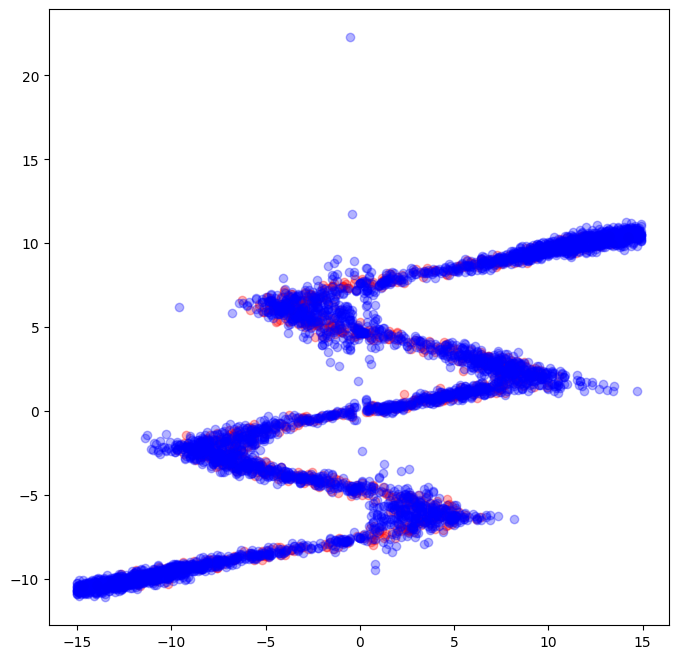

In [54]:

y = model(x_test)
pi, mu, sigma = y
print(pi.shape, mu.shape, sigma.shape)


y_test = generate_ensemble(pi.data, mu.data, sigma.data)


plt.figure(figsize=(8, 8))
plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.plot(x_test, y_test, 'bo', alpha=0.3)
plt.show()


In [45]:
# check if sum of pi is 1
print(pi.data.shape)

for i in range(10):
    print(np.sum(pi.data[i]))

(300, 24)
1.0
0.9999999
0.9999999
0.99999994
0.99999994
1.0
1.0
0.99999994
1.0
1.0


In [ ]:
# now let's try with bivariate gaussian

